# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
import signal
 
from contextlib import contextmanager
 
import requests
 
DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}
 
def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler
 
@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:
 
    from workspace_utils import active session
 
    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)
 
 
def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:
 
    from workspace_utils import keep_awake
 
    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np



# the implementation closely follows the DDPG paper
# Paper: https://arxiv.org/pdf/1509.02971.pdf



def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1.0 / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model"""
    def __init__(self, state_size, action_size, seed, hidden1=400, hidden2=300):
        super(Actor, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        
        self.fc1 = nn.Linear(state_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, action_size)
        self.tanh = nn.Tanh()
        # initialise the weights
        self.weight_initialiser()
        
        
    def weight_initialiser(self):
        """
        All layers but the final layer are initilaised from uniform
        distributions [-1/sqrt(f) , 1/sqrt(f)] where f is the fan-in of the layer
        """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        
        """
        The final layer is initialised from uniform distribution
        [-3*10^-3, 3*10^-3]
        """
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        
        
    def forward(self, states):
        # Actor network maps states to action probabilities 
        
        if states.dim() == 1:
            states = states.unsqueeze(0)
        
        x = F.relu(self.bn1(self.fc1(states)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc3(x))

        return F.tanh(self.fc4(x))
    
    
class Critic(nn.Module):
    """Critic (Value) Model"""
    def __init__(self, state_size, action_size, seed, hidden1=400, hidden2=300):
        super(Critic, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        # we are including actions along with states in the first layer itself
         
        self.fc1 = nn.Linear(state_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512 + action_size, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.weight_initialiser()
    
    def weight_initialiser(self):
        """
        All layers but the final layer are initilaised from uniform
        distributions [-1/sqrt(f) , 1/sqrt(f)] where f is the fan-in of the layer
        """
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        
        """
        The final layer is initialised from uniform distribution
        [-3*10^-3, 3*10^-3]
        """
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, states, actions):
        # Critic network maps (all_states, all_actions) pairs to Q-values
        if states.dim() == 1:
            states = states.unsqueeze(0)
        # concatinating all states and all actions in a 1D vector
        
        xs = F.relu(self.bn1(self.fc1(states)))
        x = torch.cat((xs, actions), dim=1)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [8]:
import numpy as np
import copy
from collections import namedtuple, deque
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# training hyperparameters
lr_actor = 1e-3                    # learning rate of Actor
lr_critic = 1e-3                   # learning rate of Critic
weight_decay = 0.                  # L2 weight decay 
gamma = 0.99                       # discount factor
tau = 1e-3                        # soft update parameter
batch_size = 1024                   # batch size to sample from replay buffer
buffer_size = int(1e5)             # max size (capacity) of the replay buffer
n_agents = 2                       # number of agents
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
update_every = 20
update_freq = 10

class MADDPGAgent(object):
    def __init__(self, state_size, action_size, seed):
        super(MADDPGAgent, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = torch.manual_seed(seed)
        
        # initialise local and target Actor networks
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.actor_optim = optim.Adam(self.actor_local.parameters(), lr = lr_actor)
        
        # initialise local and target Critic networks
        self.critic_local = Critic(state_size, action_size, seed).to(device)
        self.critic_target = Critic(state_size, action_size, seed).to(device)
        self.critic_optim = optim.Adam(self.critic_local.parameters(), lr = lr_critic, weight_decay = weight_decay)
        

        
        # initialise the Ornstein-Uhlenbeck noise process
        self.noise = OUNoise((n_agents, action_size), seed)        
        
        
        # Shared Replay Buffer
        self.memory = ReplayBuffer(buffer_size, batch_size, seed)
        
        self.t_step = 0
        
    def hard_update(self, local_model, target_model):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)
            
            
    def step(self, states, actions, rewards, next_states, dones):
        
        # each agent adding their experience tuples in the replay buffer
        for i in range(n_agents):
            self.memory.add(states[i, :], actions[i, :], rewards[i], next_states[i, :], dones[i])
            
            
        self.t_step = (self.t_step + 1) % update_every
        if self.t_step == 0:
            # if enough samples are there then learn
            if len(self.memory) > batch_size:
                for i in range(update_freq):
                    experiences = self.memory.sample()
                    self.learn(experiences, gamma)
        
        
    def act(self, states, add_noise=True):
            """Returns actions for given state as per current policy"""
            states = torch.from_numpy(states).float().to(device)
            actions = np.zeros((n_agents, self.action_size))
                               
            self.actor_local.eval()

            # get the actions for each agent
            with torch.no_grad():
                for i in range(n_agents):
                    action_i = self.actor_local(states[i]).cpu().data.numpy()
                    actions[i, :] = action_i
                               
            self.actor_local.train()

            # Ornstein-Uhlenbeck noise process           
            if add_noise:
                actions += self.noise.sample()

            return np.clip(actions, -1, 1)

    
    def reset(self):
        self.noise.reset()
        
        
    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, dones = experiences
        
        # update critic
        
        # Get the actions corresponding to next states and then their Q-values
        # from target critic network
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Now minimize this loss
        self.critic_optim.zero_grad()
        critic_loss.backward()
        
        # gradient clipping as suggested
        nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)

        self.critic_optim.step()
        
        
        # Update Actor
        # Compute Actor loss
        actions_pred = self.actor_local(states)
        
        # -ve sign because we want to maximise this value
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # minimizing the loss
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()
        
        
        # update target networks
        self.soft_update(self.critic_local, self.critic_target, tau)
        self.soft_update(self.actor_local, self.actor_target, tau)
        
    def soft_update(self, local_model, target_model, tau):
        """
            Soft update model parameters.
            θ_target = τ*θ_local + (1 - τ)*θ_target
            Params
            ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

        
# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
        
class OUNoise(object):
    """Ornstein-Uhlenbeck process"""
    
    def __init__(self, size, seed, mu=0.0, theta=0.15, sigma=0.2):
        """ initialise noise parameters """
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.dt = 1e-2
        self.seed = torch.manual_seed(seed)
        self.reset()
        
    def reset(self):
        """reset the internal state to mean (mu)"""
        self.state = copy.copy(self.mu)
        
    def sample(self):
        """Update internal state and return it as a noise sample"""
        x = self.state
        dx = self.theta * (self.mu - x) * self.dt + self.sigma * np.sqrt(self.dt) * np.array([np.random.normal() for i in range(len(x))])
        self.state = x + dx
        return self.state
    
    
    
class ReplayBuffer(object):
    """Replay buffer to store experience tuples"""
    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:



agent = MADDPGAgent(state_size=state_size, action_size=action_size, seed=0)

In [10]:
def train(n_episodes=50000, max_t=1000):
    scores = [] # list to store the scores (averaged over all agents) estimated from each episode of training
    scores_window = deque(maxlen=100) # last 100 averaged (over all agents) scores
    scores_mean = [] # list to store the avg score (averaged over all agents) for 100 consecutive episodes
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        # set initial value of score as 0
        scores_list = np.zeros(num_agents) # list to store the scores of each agent for very episode
        # get initial state ===> dimension will be (num_agents,)
        states = env_info.vector_observations
        # resetting the noise process
        agent.reset()
        for t_step in range(max_t):
            # taking actions based upon current estimate of DDPG policy for all agents
            actions = agent.act(states)
            # now sending these actions to the envirnonment so that each agent can transition to the next state indepemdently
            env_info = env.step(actions)[brain_name]
            # get the next states ===> dimension will be (num_agents,)
            next_states = env_info.vector_observations
            # get the rewards
            rewards = env_info.rewards
            dones = env_info.local_done
            # now the agents learns from these experience tuples
            agent.step(states, actions, rewards, next_states, dones)
            # current_state <==== next_state
            states = next_states
            # appending each agent immediate reward to it total undiscounted score
            scores_list += rewards
            # check if any of the agents have reach the end of episode
            if np.any(dones):
                break
        # episode ends here 
        #max of scores of all agents for this episode
        score_for_this_episode = np.max(scores_list)
        scores_window.append(score_for_this_episode)
        final_score = np.mean(scores_window) 
        scores.append(score_for_this_episode)
        print ("\rEpisode {:}\t Average Score {:.2f}".format(i_episode, final_score), end="")
        if i_episode % 100 == 0:
            print ("\rEpsiode {:}\t Average Score {:.2f}".format(i_episode, final_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic1.pth')
 
        if i_episode >= 100:
            scores_mean.append(final_score) # appending final score
 
        if final_score >= 0.50: 
            print ("\nEnvironment solved in {:d} episodes!\tAverage Score: {:2f}".format(i_episode-100, final_score))
            torch.save(agent.actor_local.state_dict(), "checkpoint_actor.pth")
            torch.save(agent.critic_local.state_dict(), "checkpoint_critic.pth")
            break
    return scores, scores_mean, agent

In [11]:
with active_session():
    dscores, dscores_mean, agent = train()

Epsiode 100	 Average Score 0.00
Epsiode 200	 Average Score 0.00
Epsiode 300	 Average Score 0.00
Epsiode 400	 Average Score 0.00
Epsiode 500	 Average Score 0.00
Epsiode 600	 Average Score 0.03
Epsiode 700	 Average Score 0.09
Epsiode 800	 Average Score 0.07
Epsiode 900	 Average Score 0.11
Epsiode 1000	 Average Score 0.17
Epsiode 1100	 Average Score 0.46
Episode 1112	 Average Score 0.50
Environment solved in 1012 episodes!	Average Score: 0.501300


In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(dscores)+1), dscores)
plt.title('agent')
plt.ylabel('score')
plt.xlabel('Ep #')
plt.show()

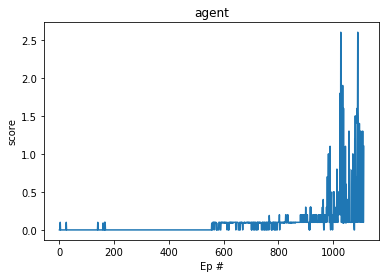

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(dscores)+1), dscores)
plt.title('agent')
plt.ylabel('score')
plt.xlabel('Ep #')
plt.show()